In [1]:
from fastai2.basics           import *
from fastai2.vision.all       import *
from fastai2.medical.imaging  import *
from fastai2.callback.tracker import *

np.set_printoptions(linewidth=120)
matplotlib.rcParams['image.cmap'] = 'bone'

First we read in the metadata files (linked in the introduction).

In [2]:
path = Path('data')
path_save = path/'saved_models'

path_trn = path/'stage_1_train_images'
path_tst = path/'stage_1_test_images'

path_meta = path/'meta'/'meta'
path_jpg = path/'train_jpg'/'train_jpg'

In [3]:
df_comb = pd.read_feather(path_meta/'comb.fth').set_index('SOPInstanceUID')
df_tst  = pd.read_feather(path_meta/'df_tst.fth').set_index('SOPInstanceUID')
df_samp = pd.read_feather(path_meta/'wgt_sample.fth').set_index('SOPInstanceUID')
bins = (path_meta/'bins.pkl').load()

## Train vs valid

To get better validation measures, we should split on patients, not just on studies, since that's how the test set is created.

Here's a list of random patients:

In [4]:
set_seed(42)
patients = df_comb.PatientID.unique()
pat_mask = np.random.random(len(patients))<0.8
pat_trn = patients[pat_mask]

In [5]:
#msss = MultilabelStratifiedShuffleSplit(n_splits=2, test_size=len(df_comb)//5, random_state=42)
#X = df_comb.PatientID
#Y = classes
#
## Get train and test index
#msss_splits = next(msss.split(X, Y))
#train_idx = msss_splits[0]
#valid_idx = msss_splits[1]

#len(train_idx), len(valid_idx), len(valid_idx)/len(train_idx)

We can use that to take just the patients in a dataframe that match that mask:

In [6]:
def split_data(df):
    idx = L.range(df)
    mask = df.PatientID.isin(pat_trn)
    return idx[mask],idx[~mask]

splits = split_data(df_samp)

In [7]:
#def split_data_stratified(df):
#    idx = L.range(df)
#    mask = df_samp.PatientID.isin(df_comb.iloc[train_idx].PatientID.values)
#    return idx[mask],idx[~mask]
#
#splits = split_data_stratified(df_samp)

Let's double-check that for a patient in the training set that their images are all in the first split.

In [8]:
df_trn = df_samp.iloc[splits[0]]
p1 = L.range(df_samp)[df_samp.PatientID==df_trn.PatientID[0]]
assert len(p1) == len(set(p1) & set(splits[0]))

## Prepare sample DataBunch

We will grab our sample filenames for the initial pretraining.

In [9]:
def filename(o): return os.path.splitext(os.path.basename(o))[0]

fns = L(list(df_samp.fname)).map(filename)
fn = fns[0]
fn

'ID_2a8702d25'

We need to create a `DataBunch` that contains our sample data, so we need a function to convert a filename (pointing at a DICOM file) into a path to our sample JPEG files:

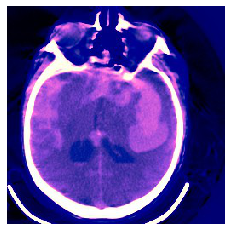

In [10]:
def fn2image(fn): return PILCTScan.create((path_jpg/fn).with_suffix('.jpg'))
fn2image(fn).show();

We also need to be able to grab the labels from this, which we can do by simply indexing into our sample `DataFrame`.

In [11]:
htypes = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
def fn2label(fn): return df_comb.loc[fn][htypes].values.astype(np.float32)
fn2label(fn)

array([1., 0., 1., 1., 0., 0.], dtype=float32)

If you have a larger GPU or more workers, change batchsize and number-of-workers here:

In [12]:
bs,nw = 128, 16

We're going to use fastai's new [Transform Pipeline API](http://dev.fast.ai/pets.tutorial.html) to create the DataBunch, since this is extremely flexible, which is great for intermediate and advanced Kagglers. (Beginners will probably want to stick with the Data Blocks API). We create two transform pipelines, one to open the image file, and one to look up the label and create a tensor of categories.

In [13]:
tfms = [[fn2image], [fn2label,EncodedMultiCategorize(htypes)]]

dsrc = DataSource(fns, tfms, splits=splits)

#nrm = Normalize(tensor([0.6]),tensor([0.25]))
nrm = Normalize(tensor([0.1627, 0.1348, 0.1373]), tensor([0.2961, 0.2605, 0.1889]))

aug = aug_transforms(max_lighting=0.1) #p_lighting=0.

batch_tfms = [IntToFloatTensor(), nrm, Cuda(), *aug]

To support progressive resizing (one of the most useful tricks in the deep learning practitioner's toolbox!) we create a function that returns a dataset resized to a requested size:

In [14]:
def get_data(bs, sz):
    return dsrc.databunch(bs=bs, num_workers=nw, after_item=[ToTensor],
                          after_batch=batch_tfms+[AffineCoordTfm(size=sz)])

Let's try it out!

(tensor(1.2544), tensor(1.5780), torch.Size([128, 3, 96, 96]), 902)

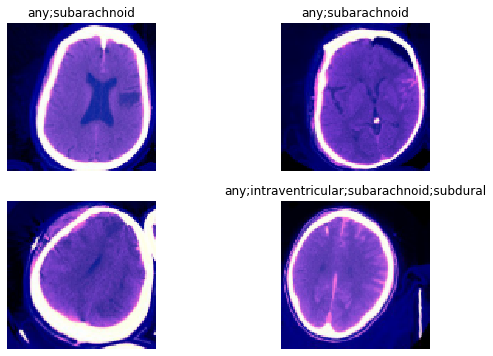

In [15]:
dbch = get_data(128, 96)
xb,yb = to_cpu(dbch.one_batch())
dbch.show_batch(max_n=4, figsize=(9,6))
xb.mean(),xb.std(),xb.shape,len(dbch.train_dl)

Let's track the accuracy of the *any* label as our main metric, since it's easy to interpret.

In [16]:
def accuracy_any(inp, targ, thresh=0.5, sigmoid=True):
    inp,targ = flatten_check(inp[:,0],targ[:,0])
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

The loss function in this competition is weighted, so let's train using that loss function too.

In [17]:
def get_loss(scale=1.0):
    loss_weights = tensor(2.0, 1, 1, 1, 1, 1).cuda()*scale
    return BaseLoss(nn.BCEWithLogitsLoss, pos_weight=loss_weights, floatify=True, flatten=False, 
        is_2d=False, activation=torch.sigmoid)

We'll scale the loss initially to account for our sampling (since the original data had 14% rows with a positive label, and we resampled it to 50/50).

In [18]:
loss_func = get_loss(scale=1.0) #get_loss(0.14*2) 

In [19]:
opt_func = partial(Adam, wd=0.01, eps=1e-3)

metrics=[accuracy_multi,accuracy_any]

Now we're ready to create our learner. We can use mixed precision (fp16) by simply adding a call to `to_fp16()`!

In [20]:
def get_learner():
    dbch = get_data(128,128)
    learn = cnn_learner(dbch, xresnet50, loss_func=loss_func, opt_func=opt_func, metrics=metrics)
    return learn.to_fp16()

In [21]:
learn = get_learner()

In [22]:
learn.model_dir = path_save

Leslie Smith's famous LR finder will give us a reasonable learning rate suggestion.

In [ ]:
lrf = learn.lr_find()

## Pretrain on sample

Here's our main routine for changing the size of the images in our DataBunch, doing one fine-tuning of the final layers, and then training the whole model for a few epochs.

In [23]:
def do_fit(bs,sz,epochs,lr, freeze=True, save_name='best'):
    learn.dbunch = get_data(bs, sz)
    if freeze:
        if learn.opt is not None: learn.opt.clear_state()
        learn.freeze()
        learn.fit_one_cycle(1, slice(lr))
    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr), cbs=SaveModelCallback(fname=save_name))

Now we can pre-train at different sizes.

we can use `torch.cuda.empty_cache()` if anything goes wrong to reset the gpu memory allocation

## short training

In [ ]:
#do_fit(512, 96, 4, 1e-2, save_name='xresnet50_96px_sample')

In [ ]:
#do_fit(192, 160, 3, 1e-3, save_name='xresnet50_96px_sample')

## test with lightning augmentation

In [ ]:
#do_fit(256, 96, 4, 1e-2, save_name='xresnet50_96px_sample_lightaugs')

In [ ]:
#learn = learn.load('xresnet50_96px_sample_lightaugs')

In [ ]:
#do_fit(192, 160, 4, 2e-3, save_name='xresnet50_160px_sample_lightaugs')

In [ ]:
#learn = learn.load('xresnet50_160px_sample_lightaugs')

In [ ]:
#do_fit(80, 256, 5, 2e-3, save_name='xresnet50_256px_sample_lightaugs')

In [23]:
learn = learn.load('xresnet50_256px_sample_lightaugs')

### best so far: 
1. new normalization, no lightning aug
2. new normalization, 0.1 lightning aug

## Scale up to full dataset

Now let's fine tune this model on the full dataset. We'll need all the filenames now, not just the sample.

In [23]:
fns = L(list(df_comb.fname)).map(filename)
splits = split_data(df_comb)

These functions are copied nearly verbatim from our [earlier cleanup notebook](https://www.kaggle.com/jhoward/cleaning-the-data-for-rapid-prototyping-fastai), so have a look there for details.

In [24]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

In [25]:
def dcm_tfm(fn): 
    fn = (path_trn/fn).with_suffix('.dcm')
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    px = x.scaled_px
    return TensorImage(px.to_3chan(dicom_windows.brain,dicom_windows.subdural, bins=bins))

torch.Size([3, 512, 512])

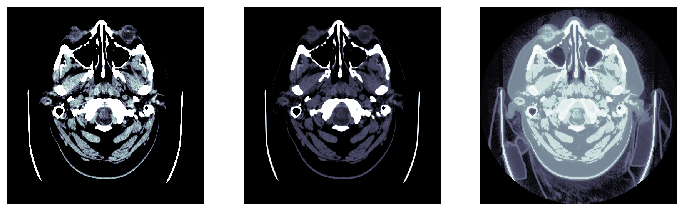

In [26]:
dcm = dcm_tfm(fns[0])
show_images(dcm)
dcm.shape

We have some slight changes to our data source

In [27]:
tfms = [[dcm_tfm], [fn2label,EncodedMultiCategorize(htypes)]]

dsrc = DataSource(fns, tfms, splits=splits)

nrm_full = Normalize(tensor([0.1627, 0.1348, 0.1373]), tensor([0.2961, 0.2605, 0.1889]))

batch_tfms = [nrm_full, Cuda(), *aug]

In [28]:
def get_data(bs, sz):
    return dsrc.databunch(bs=bs, num_workers=nw, after_batch=batch_tfms+[AffineCoordTfm(size=sz)])

Now we can test it out:

torch.Size([128, 3, 96, 96])

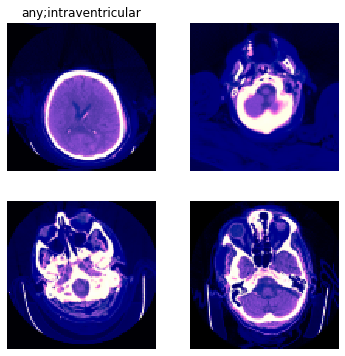

In [29]:
dbch = get_data(128,96)
x,y = to_cpu(dbch.one_batch())
dbch.show_batch(max_n=4)
x.shape

We need to remove the sample scaling from our loss function, since we're using the full dataset.

In [30]:
learn.loss_func = get_loss(1.0)

We can now fine-tune the final layers.

In [31]:
def fit_tune(bs, sz, epochs, lr, save_name='best'):
    dbch = get_data(bs, sz)
    learn.dbunch = dbch
    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr), cbs=SaveModelCallback(fname=save_name))

## short training

In [34]:
#fit_tune(80, 256, 1, 1e-3)

In [35]:
#fit_tune(64, 352, 1, 3e-4)

## long training

In [36]:
learn.opt.clear_state()

In [38]:
fit_tune(48, 352, 3, 2e-3, save_name='xresnet50_352px_full')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.088845,0.089602,0.971907,0.944196,4:52:18
1,0.079211,0.079382,0.974376,0.949403,4:52:21
2,0.062249,0.074797,0.975938,0.952688,4:53:45


data/stage_1_train_images/ID_e261682bf.dcm File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
data/stage_1_train_images/ID_82b0835e9.dcm File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
data/stage_1_train_images/ID_e261682bf.dcm File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
data/stage_1_train_images/ID_82b0835e9.dcm File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
data/stage_1_train_images/ID_82b0835e9.dcm File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
data/stage_1_train_images/ID_e261682bf.dcm File is missing DICOM File Meta Information header or the 'DICM' prefix is mi

In [34]:
learn = learn.load('xresnet50_352px_full')

In [156]:
fit_tune(20, 512, 3, 2e-3, save_name='xresnet50_512px_full')

#0 	0.098705 	0.095523 	0.970804 	0.944516 	6:04:11

## Prepare for submission

In [157]:
learn = learn.load('xresnet50_512px_full')

In [162]:
learn.cbs

(#6) [TrainEvalCallback,Recorder,ProgressCallback,MixedPrecision,ParamScheduler,GatherPredsCallback]

In [161]:
#learn.remove_cbs(learn.cbs.items[-1])

Now we're ready to submit. We can use the handy `test_dl` function to get an inference `DataLoader` ready, then we can check it looks OK.

In [163]:
test_fns = [(path_tst/f'{filename(o)}.dcm').absolute() for o in df_tst.fname.values]

In [165]:
dbch = get_data(48, 352)

In [166]:
tst = test_dl(dbch, test_fns)
x = tst.one_batch()[0]
x.min(),x.max()

(tensor(-0.7268, device='cuda:0'), tensor(4.5670, device='cuda:0'))

We pass that to `get_preds` to get our predictions, and then clamp them just in case we have some extreme values.

In [44]:
preds,targs = learn.get_preds(dl=tst)
preds_clipped = preds.clamp(.0001, .999)

## TTA

In [185]:
def _tta_only(learn:Learner, scale:float=1.1):
    "Computes the outputs for several augmented inputs for TTA"
    for i in range(8):
        p_affine = i&4>0
        zoom = 1.0 if i&2 else scale
        p_lighting = i&1>0
        aug = aug_transforms(max_lighting=0.1, max_zoom=zoom, p_affine=p_affine, p_lighting=p_lighting)
        batch_tfms = [IntToFloatTensor(), nrm, Cuda(), *aug]
        dbch = get_data(48, 352)
        print(f"iteration: {i}  p_affine: {p_affine>0}, zoom: {zoom}, p_lighting {p_lighting>0}")
        yield learn.get_preds(dl=test_dl(dbch, test_fns))[0]

Learner.tta_only = _tta_only

In [186]:
def _TTA(learn:Learner, test_dl, beta:float=0.4, scale:float=1.1, with_loss:bool=False):
    "Applies TTA to predict on `ds_type` dataset."
    preds,y = learn.get_preds(dl=test_dl)
    all_preds = list(learn.tta_only(scale=scale))
    avg_preds = torch.stack(all_preds).mean(0)
    if beta is None: return preds,avg_preds,y
    else:
        final_preds = preds*beta + avg_preds*(1-beta)
        return final_preds, y

Learner.TTA = _TTA

In [187]:
preds_tta = learn.TTA(tst, beta=0.2, scale=1.1)

iteration: 0  p_affine: False, zoom: 1.1, p_lighting False


iteration: 1  p_affine: False, zoom: 1.1, p_lighting True


iteration: 2  p_affine: False, zoom: 1.0, p_lighting False


iteration: 3  p_affine: False, zoom: 1.0, p_lighting True


iteration: 4  p_affine: True, zoom: 1.1, p_lighting False


iteration: 5  p_affine: True, zoom: 1.1, p_lighting True


iteration: 6  p_affine: True, zoom: 1.0, p_lighting False


iteration: 7  p_affine: True, zoom: 1.0, p_lighting True


In [191]:
preds_clipped = preds_tta[0].clamp(.0001, .999)

I'm too lazy to write a function that creates a submission file, so this code is stolen from Radek, with minor changes.

In [192]:
ids = []
labels = []

for idx,pred in zip(df_tst.index, preds_clipped):
    for i,label in enumerate(htypes):
        ids.append(f"{idx}_{label}")
        predicted_probability = '{0:1.10f}'.format(pred[i].item())
        labels.append(predicted_probability)

In [193]:
df_csv = pd.DataFrame({'ID': ids, 'Label': labels})
df_csv.to_csv(f'submission.csv', index=False)
df_csv.head()

,ID,Label
0,ID_e3674b189_any,0.0061450927
1,ID_e3674b189_epidural,0.0001000000
2,ID_e3674b189_intraparenchymal,0.0004305571
3,ID_e3674b189_intraventricular,0.0001572035
4,ID_e3674b189_subarachnoid,0.0008626078


Run the code below if you want a link to download the submission file.

In [194]:
from IPython.display import FileLink, FileLinks
FileLink('submission.csv')

/run/media/windisk/Users/chrun/Documents/Projects/RSNA-intracranial-hemorrhage-detection/submission.csv